In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [108]:
def compare_matches(img1, img2, padded_img1, padded_img2, center1, center2, patch_half_size, debug=False):
    height, width, _ = img1.shape
    
    i1_start = center1[1]-patch_half_size
    i1_end = center1[1]+patch_half_size+1
    j1_start = center1[0]-patch_half_size
    j1_end = center1[0]+patch_half_size+1
    
    i2_start = center2[1]-patch_half_size
    i2_end = center2[1]+patch_half_size+1
    j2_start = center2[0]-patch_half_size
    j2_end = center2[0]+patch_half_size+1
    
    
    
    if i1_start >=0 and i1_end <= height and j1_start >= 0 and j1_end <= width and \
        i2_start >=0 and i2_end <= height and j2_start >= 0 and j2_end <= width:
        # assume everything is fine with patch

        patch_1 = img1[i1_start:i1_end, j1_start:j1_end]
        patch_2 = img2[i2_start:i2_end, j2_start:j2_end]
        
        if debug:
            print(patch_1)
            print(patch_2)
    else:
        # patch is crossing the image border
        if debug:
            print(padded_img1)
            print(padded_img2)
        
        i1_start += patch_half_size
        i1_end += patch_half_size 
        j1_start += patch_half_size
        j1_end += patch_half_size 

        i2_start += patch_half_size
        i2_end += patch_half_size 
        j2_start += patch_half_size
        j2_end += patch_half_size 
        
        patch_1 = padded_img1[i1_start:i1_end, j1_start:j1_end]
        patch_2 = padded_img2[i2_start:i2_end, j2_start:j2_end]
        
        if debug:
            print(patch_1)
            print(patch_2)
        
        mask = np.logical_and(patch_1 >= 0,patch_2 >= 0)
        patch_1 = patch_1[mask]
        patch_2 = patch_2[mask]
        
        
    return np.sum((patch_1-patch_2)**2)/patch_1.size
        
def patch_match(img1, img2, patch_size=11):
    height, width, ch = img1.shape
    # create random ofset with the shape h*w for dy and dx
    match_x = np.random.randint(0, width, size=(height,width))
    match_y = np.random.randint(0, height, size=(height,width))
    
    patch_half_size = patch_size // 2
    padded_img1 = -1*np.ones([height+2*patch_half_size, width+2*patch_half_size, ch], dtype=int)
    padded_img2 = -1*np.ones([height+2*patch_half_size, width+2*patch_half_size, ch], dtype=int)
    padded_img1[patch_half_size:patch_half_size+height, patch_half_size:patch_half_size+width] = img1
    padded_img2[patch_half_size:patch_half_size+height, patch_half_size:patch_half_size+width] = img2
    
    iteration = 0
    
    while iteration<5:
        # choose direction of propagation
        if iteration % 2 == 0:
            iter_i = range(height)
            iter_j = range(width)
            edge_i = 0
            edge_j = 0
            delta = -1
        else:
            iter_i = range(height-1, -1, -1)
            iter_j = range(width-1, -1, -1)
            edge_i = height-1
            edge_j = width-1
            delta = 1
           
        # propagate
        # y
        for i in iter_i:
            # x
            for j in iter_j:
                
                current_x = match_x[i][j]
                current_y = match_y[i][j]
                candidates = [[current_x, current_y]]
                if i != edge_i:
                    candidates.append([match_x[i+delta][j], match_y[i+delta][j]])
                if j != edge_j:
                    candidates.append([match_x[i][j+delta], match_y[i][j+delta]])
                if len(candidates) == 1:
                    continue

                
                distances = [compare_matches(img1, img2, padded_img1, padded_img2, \
                                             [j, i], candidates[k], patch_half_size) for k in range(len(candidates))]
                min_dist_index = np.argmin(distances)
                min_dist = distances[min_dist_index]
                top_candidate = candidates[min_dist_index]

                match_x[i][j] = top_candidate[0]
                match_y[i][j] = top_candidate[1]        
        
                # random search around
                wa_x = width // 2
                wa_y = height // 2
                
                while wa_x >= 1 and wa_y >= 1:
                    deltas = [-1,1] 
                    candidate_x = current_x + wa_x * deltas[np.random.randint(0,2)]
                    candidate_y = current_y + wa_y * deltas[np.random.randint(0,2)]
                    
                    candidate_x = candidate_x % width
                    candidate_y = candidate_y % height
                    
                    distance = compare_matches(img1, img2, padded_img1, padded_img2, \
                                               [j, i], [candidate_x, candidate_y], patch_half_size)
                    if distance < min_dist:
                        match_x[i][j] = candidate_x
                        match_y[i][j] = candidate_y
                        min_dist = distance
                    
                    wa_x = wa_x // 2
                    wa_y = wa_y // 2
        
        iteration += 1
    
    ref_i = [np.ones(width, dtype=int)*i for i in range(height)]
    ref_j = [list(range(width)) for i in range(height)]
    
        
    return match_x-ref_j, match_y-ref_i

In [106]:
a = np.array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],
             [[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]] ,
             [[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]]])

b = np.array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],
             [[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]] ,
             [[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]]])
print(a)

[[[0 1 2]
  [3 4 5]
  [6 7 8]]

 [[0 1 2]
  [3 4 5]
  [6 7 8]]

 [[0 1 2]
  [3 4 5]
  [6 7 8]]]


In [109]:
patch_match(a,b,3)

(array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]), array([[ 2,  2,  1],
        [ 1,  1,  0],
        [ 0,  0, -1]]))

In [110]:
frame_1 = cv2.resize(cv2.cvtColor(cv2.imread("./v001.jpg"), cv2.COLOR_BGR2RGB),(320,180))
frame_5 = cv2.resize(cv2.cvtColor(cv2.imread("./v005.jpg"), cv2.COLOR_BGR2RGB),(320,180))
frame_50 = cv2.resize(cv2.cvtColor(cv2.imread("./v050.jpg"), cv2.COLOR_BGR2RGB),(320,180))
frame_100 = cv2.resize(cv2.cvtColor(cv2.imread("./v100.jpg"), cv2.COLOR_BGR2RGB),(320,180))


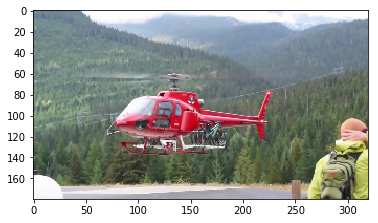

In [111]:
plt.imshow(frame_1)

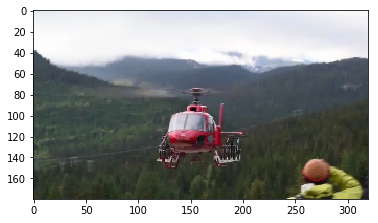

In [112]:
plt.imshow(frame_50)

In [113]:
%%time
dx, dy = patch_match(frame_1, frame_50, patch_size=31)

Wall time: 1min 26s


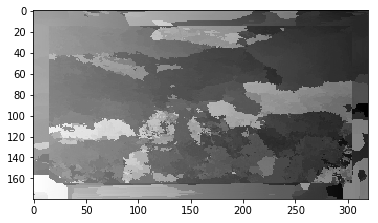

In [116]:
plt.imshow(dx, cmap="gray")

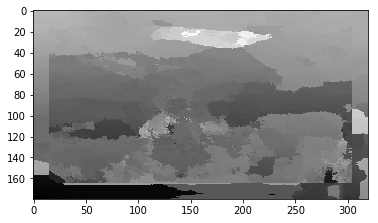

In [117]:
plt.imshow(dy, cmap="gray")

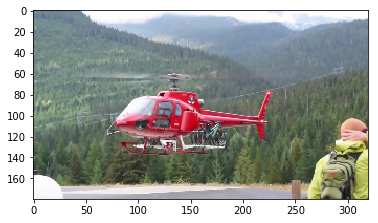

In [118]:
plt.imshow(frame_1)

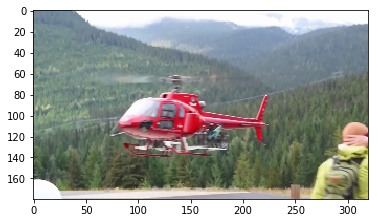

In [119]:
plt.imshow(frame_5)

In [120]:
%%time
dx, dy = patch_match(frame_1, frame_5, patch_size=31)

Wall time: 1min 41s


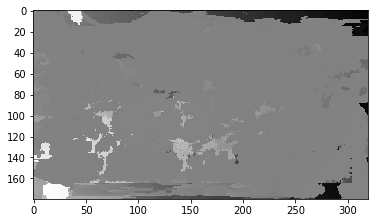

In [121]:
plt.imshow(dx, cmap="gray")

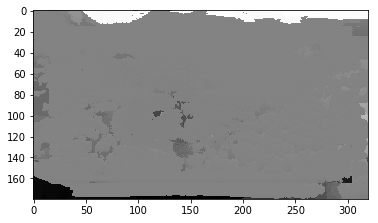

In [122]:
plt.imshow(dy, cmap="gray")

In [123]:
%%time
dx, dy = patch_match(frame_1, frame_5, patch_size=21)

Wall time: 1min 7s


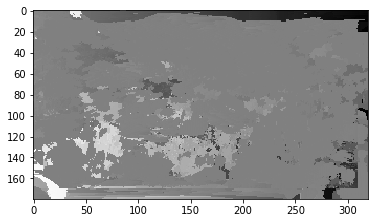

In [124]:
plt.imshow(dx, cmap="gray")

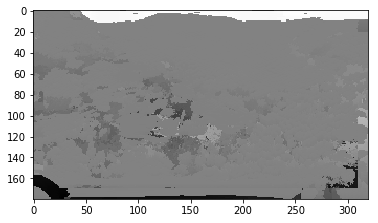

In [125]:
plt.imshow(dy, cmap="gray")